In [7]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from default_func import extract_image_file_name_from_lidar_file_name, extract_bboxes_file_name_from_image_file_name, extract_semantic_file_name_from_image_file_name

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
print(torch.cuda.is_available())

True


In [3]:
# Проверяем, доступны ли GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [8]:
from os.path import join
import glob

root_path_train = '.\\camera_lidar_semantic_bboxes\\train\\'
# get the list of files in lidar directory
file_names_lidar_train = sorted(glob.glob(join(root_path_train, '*\\lidar\\cam_front_center\\*.npz')))

root_path_test = '.\\camera_lidar_semantic_bboxes\\test\\'
# get the list of files in lidar directory
file_names_lidar_test = sorted(glob.glob(join(root_path_test, '*\\lidar\\cam_front_center\\*.npz')))

file_names_photo_train = []

for file_name_lidar in file_names_lidar_train:
    seq_name = file_name_lidar.split('\\')[3]
    file_name_image = extract_image_file_name_from_lidar_file_name(file_name_lidar)
    file_name_image = join(root_path_train, seq_name, 'camera\\cam_front_center\\', file_name_image)
    file_names_photo_train.append(file_name_image)

file_names_photo_test = []

for file_name_lidar in file_names_lidar_test:
    seq_name = file_name_lidar.split('\\')[3]
    file_name_image = extract_image_file_name_from_lidar_file_name(file_name_lidar)
    file_name_image = join(root_path_test, seq_name, 'camera\\cam_front_center\\', file_name_image)
    file_names_photo_test.append(file_name_image)

file_names_seg_maps_train = []

for file_name_image, file_name_lidar in zip(file_names_photo_train, file_names_lidar_train):
    seq_name = file_name_lidar.split('\\')[3]
    file_name_semantic_label = extract_semantic_file_name_from_image_file_name(file_name_image)
    file_name_semantic_label = join(root_path_train, seq_name, 'label\\cam_front_center\\', file_name_semantic_label)
    #semantic_image_front_center = cv2.imread(file_name_semantic_label)
    file_names_seg_maps_train.append(file_name_semantic_label)

file_names_seg_maps_test = []

for file_name_image, file_name_lidar in zip(file_names_photo_test, file_names_lidar_test):
    seq_name = file_name_lidar.split('\\')[3]
    file_name_semantic_label = extract_semantic_file_name_from_image_file_name(file_name_image)
    file_name_semantic_label = join(root_path_test, seq_name, 'label\\cam_front_center\\', file_name_semantic_label)
    file_names_seg_maps_test.append(file_name_semantic_label)

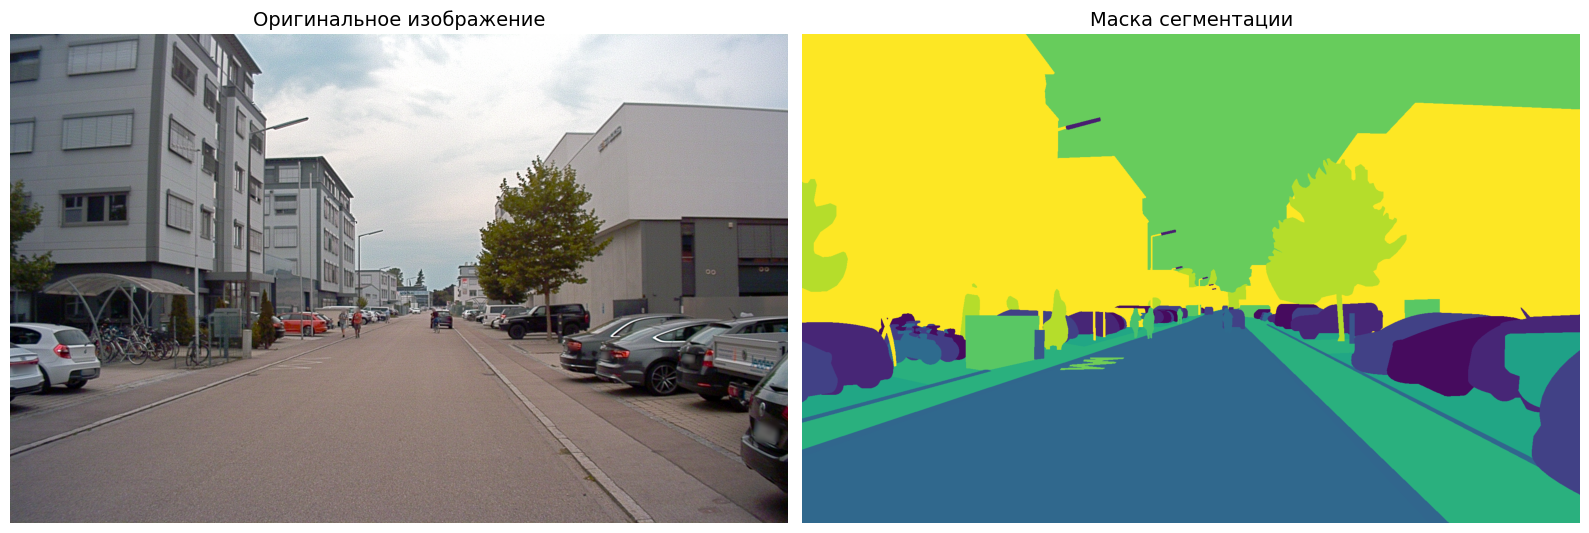

Размер изображения: (1208, 1920, 3)
Размер маски: (1208, 1920, 1)
Уникальные значения в маске: [ 38  44  55  59  74  76  90 103 105 107 151 155 164 179 185 190 193 214
 236]


In [8]:
import cv2
import torch
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

# Загрузка и преобразование оригинального изображения
image_front_center = cv2.imread(file_names_photo_train[0])
image_front_center = cv2.cvtColor(image_front_center, cv2.COLOR_BGR2RGB)

# Загрузка маски сегментации
semantic_image_front_center = cv2.imread(file_names_seg_maps_train[0], cv2.IMREAD_GRAYSCALE)

# Преобразование в тензор
tensor_mask = torch.from_numpy(semantic_image_front_center)

# Добавление dimension для канала (H, W) -> (1, H, W)
tensor_mask = tensor_mask.unsqueeze(0)

# Нормализация
tensor_mask = tensor_mask.float() / 255.0

# Подготовка маски для отображения
mask_np = tensor_mask.permute(1, 2, 0).numpy()    # (H, W, 1)

# Если маска была нормализована, возвращаем к [0, 255]
if mask_np.max() <= 1.0:
    mask_np = (mask_np * 255).astype(np.uint8)

# Создаем subplot
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Отображаем оригинальное изображение
axes[0].imshow(image_front_center)
axes[0].set_title('Оригинальное изображение', fontsize=14)
axes[0].axis('off')

# Отображаем маску сегментации
# Маска одноканальная, используем grayscale colormap
axes[1].imshow(mask_np[:, :, 0], cmap='viridis')
axes[1].set_title('Маска сегментации', fontsize=14)
axes[1].axis('off')

plt.tight_layout()
plt.show()

# Дополнительная информация
print(f"Размер изображения: {image_front_center.shape}")
print(f"Размер маски: {mask_np.shape}")
print(f"Уникальные значения в маске: {np.unique(mask_np)}")

Всего классов: 55
Уникальные классы в маске: [ 0  1  2  3  4  5  6  8 11 28 34 35 38 39 40 43 44 45 50 51 52]
Найденные классы: ['Car 1', 'Car 2', 'Car 3', 'Car 4', 'Bicycle 1', 'Bicycle 2', 'Bicycle 3', 'Pedestrian 1', 'Truck 1', 'Solid line', 'Obstacles / trash', 'Poles', 'Grid structure', 'Signal corpus', 'Drivable cobblestone', 'Nature object', 'Parking area', 'Sidewalk', 'RD normal street', 'Sky', 'Buildings']
Тензор маски: torch.Size([1, 1208, 1920]), dtype: torch.int64


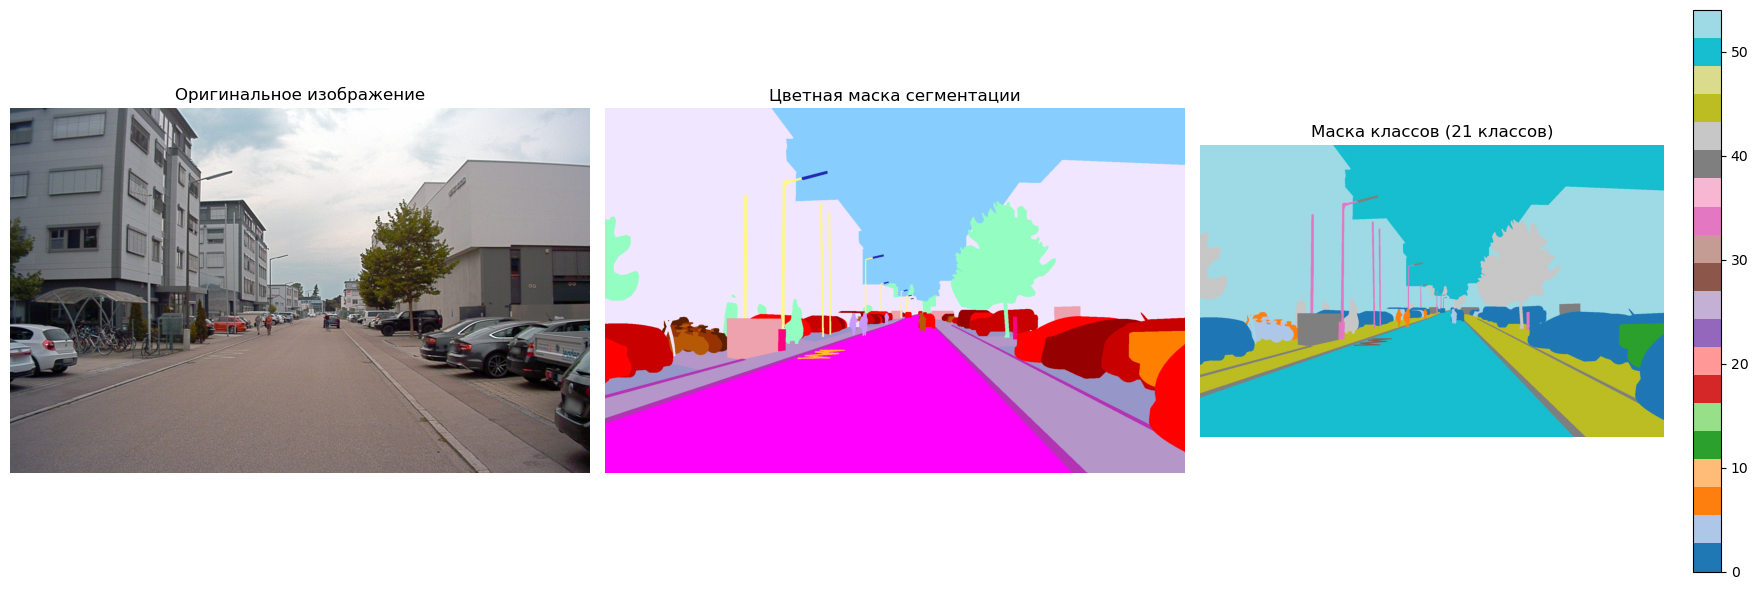

In [9]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
import json

# Загрузка class mapping из JSON
with open('.\\camera_lidar_semantic_bboxes\\class_list.json', 'r') as f:
    color_to_class_name = json.load(f)

# Создаем mapping из hex цветов в классы
hex_colors = list(color_to_class_name.keys())
class_names = list(color_to_class_name.values())

# Преобразуем hex в BGR (потому что OpenCV использует BGR)
color_mapping = {}
class_id_mapping = {}

for i, hex_color in enumerate(hex_colors):
    # Преобразуем hex в RGB
    hex_color = hex_color.lstrip('#')
    rgb = tuple(int(hex_color[j:j+2], 16) for j in (0, 2, 4))
    # OpenCV использует BGR порядок
    bgr = (rgb[2], rgb[1], rgb[0])
    
    color_mapping[bgr] = i  # mapping из BGR в class_id
    class_id_mapping[i] = class_names[i]  # mapping из class_id в название

print(f"Всего классов: {len(color_mapping)}")

# Загрузка маски как COLOR изображения (не grayscale!)
semantic_image_front_center = cv2.imread(file_names_seg_maps_train[0], cv2.IMREAD_COLOR)

# Преобразуем маску в тензор классов
def color_mask_to_class_mask(color_mask, color_mapping):
    """Преобразует RGB маску в маску классов"""
    height, width, _ = color_mask.shape
    class_mask = np.zeros((height, width), dtype=np.int64)
    
    # Создаем словарь для быстрого поиска
    bgr_colors = list(color_mapping.keys())
    class_ids = list(color_mapping.values())
    
    # Преобразуем каждый пиксель
    for i in range(height):
        for j in range(width):
            pixel_color = tuple(color_mask[i, j])
            if pixel_color in color_mapping:
                class_mask[i, j] = color_mapping[pixel_color]
            else:
                # Если цвет не найден в mapping, присваиваем фон (0)
                class_mask[i, j] = 0
    
    return class_mask

# Преобразуем маску
class_mask = color_mask_to_class_mask(semantic_image_front_center, color_mapping)

# Проверяем уникальные классы
unique_classes = np.unique(class_mask)
print(f"Уникальные классы в маске: {unique_classes}")
print(f"Найденные классы: {[class_id_mapping.get(cls, 'Unknown') for cls in unique_classes]}")

# Преобразуем в тензор
tensor_mask = torch.from_numpy(class_mask).long()  # (H, W)
tensor_mask = tensor_mask.unsqueeze(0)  # (1, H, W)

print(f"Тензор маски: {tensor_mask.shape}, dtype: {tensor_mask.dtype}")

# Визуализация
image_front_center = cv2.imread(file_names_photo_train[0])
image_front_center = cv2.cvtColor(image_front_center, cv2.COLOR_BGR2RGB)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Оригинальное изображение
axes[0].imshow(image_front_center)
axes[0].set_title('Оригинальное изображение', fontsize=12)
axes[0].axis('off')

# Цветная маска
axes[1].imshow(cv2.cvtColor(semantic_image_front_center, cv2.COLOR_BGR2RGB))
axes[1].set_title('Цветная маска сегментации', fontsize=12)
axes[1].axis('off')

# Маска классов
im = axes[2].imshow(class_mask, cmap='tab20', vmin=0, vmax=len(color_mapping)-1)
axes[2].set_title(f'Маска классов ({len(unique_classes)} классов)', fontsize=12)
axes[2].axis('off')
plt.colorbar(im, ax=axes[2])

plt.tight_layout()
plt.show()

In [5]:
from torch.utils.data import DataLoader
from segmentation_dataset import SegmentationDataset, collate_fn

train_dataset = SegmentationDataset(file_names_photo_train, file_names_seg_maps_train, image_size=(300, 300))
test_dataset = SegmentationDataset(file_names_photo_test, file_names_seg_maps_test, image_size=(300, 300))

print(f"Количество классов: {train_dataset.get_num_classes()}")

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)

Сокращено до 19 классов:
  0: bicycle
  1: building
  2: bus
  3: car
  4: crosswalk
  5: fence
  6: line
  7: motorcycle
  8: person
  9: pole
  10: road
  11: sidewalk
  12: sky
  13: terrain
  14: traffic_light
  15: traffic_sign
  16: truck
  17: unknown
  18: vegetation
Количество классов: 19


In [6]:
# Проверим первый батч
for images, masks in train_loader:
    print(f"Images shape: {images.shape}")  # [batch, 3, H, W]
    print(f"Masks shape: {masks.shape}")    # [batch, H, W]
    print(f"Masks unique values: {torch.unique(masks)}")
    break

Images shape: torch.Size([4, 3, 300, 300])
Masks shape: torch.Size([4, 300, 300])
Masks unique values: tensor([ 1,  3,  5,  6,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18])


AttributeError: 'UltraFastSegmentationDataset' object has no attribute 'get_num_classes'

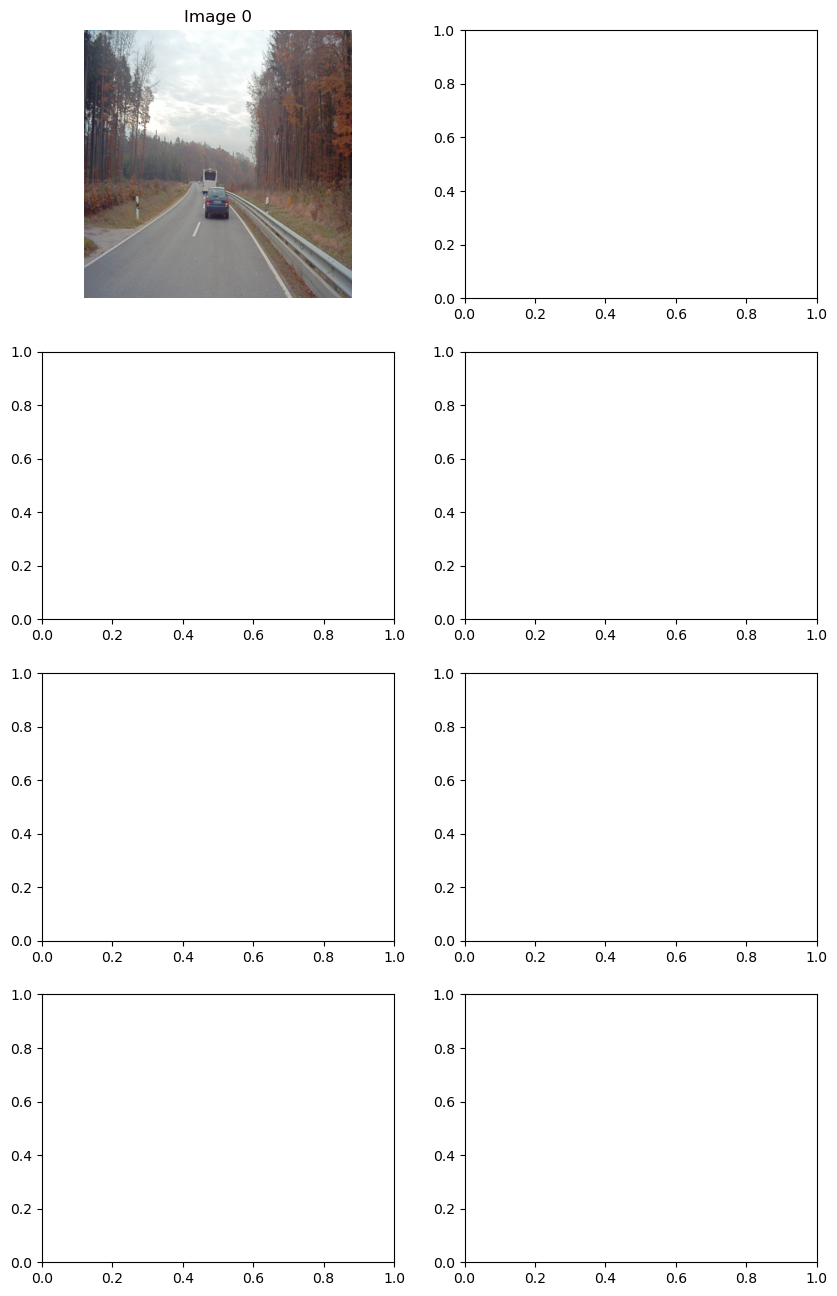

In [15]:
# Функция для визуализации батча
def visualize_batch(images, masks, num_samples=4):
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, num_samples * 4))
    
    for i in range(num_samples):
        if i >= images.shape[0]:
            break
            
        # Денормализуем изображение
        img = images[i].permute(1, 2, 0).numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        
        # Маска
        mask = masks[i].numpy()
        
        axes[i, 0].imshow(img)
        axes[i, 0].set_title(f'Image {i}')
        axes[i, 0].axis('off')
        
        im = axes[i, 1].imshow(mask, cmap='tab20', vmin=0, vmax=train_dataset.get_num_classes()-1)
        axes[i, 1].set_title(f'Mask {i}')
        axes[i, 1].axis('off')
        plt.colorbar(im, ax=axes[i, 1])
    
    plt.tight_layout()
    plt.show()

# Использование
for images, masks in train_loader:
    visualize_batch(images, masks)
    break

In [8]:
import os
import numpy as np
from tqdm import tqdm
from segmentation_dataset import *

def preprocess_all_masks_with_resize(mask_files, output_dir, target_size=(512, 512)):
    """
    Предобрабатывает маски и сразу делает resize
    """
    os.makedirs(output_dir, exist_ok=True)
    preprocessed_mask_paths = []
    
    for i, mask_path in enumerate(tqdm(mask_files, desc="Preprocessing masks with resize")):
        # Загружаем маску
        color_mask = cv2.imread(mask_path, cv2.IMREAD_COLOR)
        
        # Преобразуем в классы
        class_mask = convert_color_mask_to_classes(
            color_mask, color_to_class_id, simplified_class_mapping, new_class_to_id
        )
        
        # Resize
        class_mask_resized = cv2.resize(
            class_mask, target_size, interpolation=cv2.INTER_NEAREST
        )
        
        # Сохраняем как .npy
        output_path = os.path.join(output_dir, f"mask_{i:06d}.npy")
        np.save(output_path, class_mask_resized)
        preprocessed_mask_paths.append(output_path)
    
    return preprocessed_mask_paths

In [17]:
preprocessed_test_masks = preprocess_all_masks_with_resize(
    file_names_seg_maps_test, "preprocessed_masks/test", (512, 512)
)

Preprocessing masks with resize: 100%|██████████| 263/263 [55:57<00:00, 12.77s/it]


In [15]:
print(file_names_seg_maps_train[0])
print(file_names_seg_maps_test[0])


.\camera_lidar_semantic_bboxes\train\20180807_145028\label\cam_front_center\20180807145028_label_frontcenter_000000091.png
.\camera_lidar_semantic_bboxes\train\20181204_154421\label\cam_front_center\20181204154421_label_frontcenter_000012561.png


In [10]:
preprocessed_train_masks = preprocess_all_masks_with_resize(
    file_names_seg_maps_train, "preprocessed_masks/train", (512, 512)
)
preprocessed_test_masks = preprocess_all_masks_with_resize(
    file_names_seg_maps_test, "preprocessed_masks/test", (512, 512)
)

Preprocessing masks with resize:   0%|          | 0/263 [00:00<?, ?it/s]


AttributeError: 'NoneType' object has no attribute 'shape'

In [18]:
with open('preprocessed_masks/train_list.json', 'w') as f:
    json.dump(preprocessed_train_masks, f)

with open('preprocessed_masks/test_list.json', 'w') as f:
    json.dump(preprocessed_test_masks, f)

In [19]:
print(train_dataset.num_classes)
print(test_dataset.num_classes)

19
19


In [16]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import cv2
import numpy as np
import json

class UltraFastSegmentationDataset(Dataset):
    def __init__(self, image_files, preprocessed_mask_files, image_size=(300, 300)):
        self.image_files = image_files
        self.preprocessed_mask_files = preprocessed_mask_files
        self.image_size = image_size
        self.num_classes = 19

        # Transform для изображений (маски уже с resize)
        self.image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    def __len__(self):
        return len(self.image_files)
    
    def get_num_classes(self):
        return self.num_classes

    def __getitem__(self, idx):
        # Загружаем изображение
        img_path = self.image_files[idx]
        img = Image.open(img_path).convert("RGB")
        
        # Загружаем ПРЕДОБРАБОТАННУЮ маску (уже с resize)
        mask_path = self.preprocessed_mask_files[idx]
        mask_transformed = np.load(mask_path)
        
        # Преобразуем изображение
        img_transformed = self.image_transform(img)
        
        # Конвертируем маску в тензор
        mask_transformed = torch.from_numpy(mask_transformed).long()
        
        return img_transformed, mask_transformed
    
# Collate function для DataLoader
def collate_fn(batch):
    images = []
    masks = []
    
    for img, mask in batch:
        images.append(img)
        masks.append(mask)
    
    images = torch.stack(images, dim=0)
    masks = torch.stack(masks, dim=0)
    
    return images, masks

In [11]:
import json

with open('preprocessed_masks/train_list.json', 'r') as f:
    preprocessed_train_masks = json.load(f)

with open('preprocessed_masks/test_list.json', 'r') as f:
    preprocessed_test_masks = json.load(f)

In [17]:
# 2. Создаем быстрые датасеты
train_dataset = UltraFastSegmentationDataset(
    file_names_photo_train, preprocessed_train_masks, (512, 512)
)
test_dataset = UltraFastSegmentationDataset(
    file_names_photo_test, preprocessed_test_masks, (512, 512)
)

# 3. Создаем DataLoader (теперь будет ОЧЕНЬ быстрый)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)

In [18]:
# Проверим первый батч
for images, masks in train_loader:
    print(f"Images shape: {images.shape}")  # [batch, 3, H, W]
    print(f"Masks shape: {masks.shape}")    # [batch, H, W]
    print(f"Masks unique values: {torch.unique(masks)}")
    break

Images shape: torch.Size([4, 3, 512, 512])
Masks shape: torch.Size([4, 512, 512])
Masks unique values: tensor([ 0,  1,  2,  3,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18])


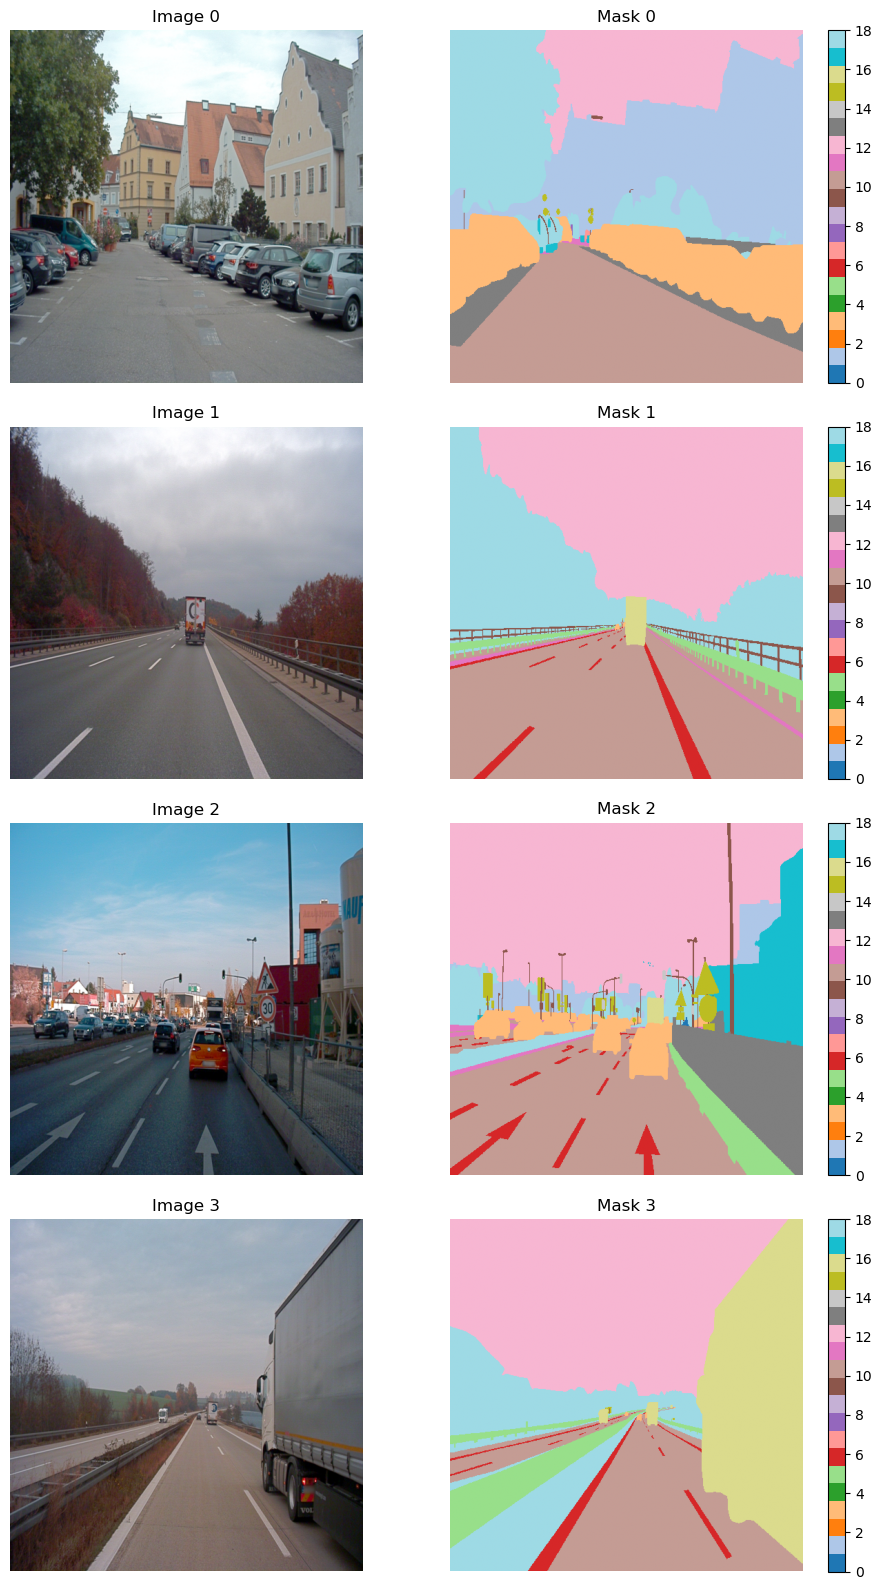

In [19]:
for images, masks in train_loader:
    visualize_batch(images, masks)
    break